### Table of Contents

### Data analysis (preprocessing, heap's law, zief's law, bigram)

### Word Clouds

### LDA
*  LDA over all years and logistic regression - unigram

* Logistic Regression

Note
Y variable is 1 = cited above median (4), 0 = anything less than 4

In [1]:
import pickle, re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import FreqDistVisualizer
import matplotlib.pyplot as plt
import numpy as np
import spacy
from stargazer.stargazer import Stargazer

# Get the data and check it

In [2]:
# unpickled_df = pd.read_pickle("C:/Users/amt/Documents/0. MSc Tinbergen/block 5. NLP/extracted_data.pkl")
#df = pd.read_pickle(r"C:\Users\marco\Desktop\NLP\extracted_data.pkl")
df = pd.read_pickle(r"C:\Users\USER\OneDrive\Documents\Python\NLP\extracted_data.pkl")
df['Cited by'] = df['Cited by'].fillna(0)
df = df.reset_index(drop = True)

In [3]:
#We drop irrelevant data
df = df.drop(1131)
df = df.reset_index(drop = True)

* Take out the nan values

In [4]:
#describing the citation data

d = df['Cited by'].describe()
d = pd.DataFrame(d).transpose()
print(d.to_latex(index=False))
d = df['Year'].describe()
d = pd.DataFrame(d).transpose()
print(d.to_latex(index=False))

\begin{tabular}{rrrrrrrr}
\toprule
 count &     mean &        std &  min &  25\% &  50\% &  75\% &    max \\
\midrule
7658.0 & 36.80726 & 135.525199 &  0.0 & 2.25 & 10.0 & 33.0 & 8657.0 \\
\bottomrule
\end{tabular}



# Corpus warm-up:

* First, make all words in abstract lower cases
* Create the corpus of abstracts

In [4]:
#lower case and save it as corpus
#suggestion: list index

def column_to_lower(df, column):
    """
        Input: df and a corresponding column
        Output: converted dataframe column 
        Function: Converts all strings in a column of a dataframe to lowercases.
    """
    return df[column].str.lower()

df.loc[:,'Abstract'] = column_to_lower(df, 'Abstract')

corpus = df["Abstract"].tolist()



In [5]:
#to count the amount of words in the entire dataset, also repeating
corpus_all = []

for i in range(0,len(corpus)):
    res = re.findall(r'\w+', str(corpus[i]))
    corpus_all.extend(res)

#corpus_all
#len(corpus_all)
#type(corpus_all)
#print(corpus_all)

In [6]:
#we are adding marketing to our stopwords list
#What kinds of words should we include in our stopwords list?
techstop = []
file = open("techstop.txt", "r") #Ask HyeJin to give you the file. Otherwise, 

for line in file:
    line = line.rstrip('\n')
    techstop.append(line)

file.close()

my_stop_words = text.ENGLISH_STOP_WORDS.union(["marketing", "consumer", "customer", 'consumers', 'elsevi',
                                               'customers',  "ieee", "rights", "reserve", 'rights reserve','science',
                                              'haworth', 'press', 'journal', 'springer', "©", "academy"], techstop)



* Create a list all the unique words in the corpus

In [16]:
#counting unqiue words in coprus

lister = []
for i in corpus_all:
    if i not in lister:
        lister.append(i)
            
#print(lister)
print("There are", len(lister), "unique words in that list")

There are 9786 unique words in that list


* Tokenize and check the words most frequent in the entire corpus

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

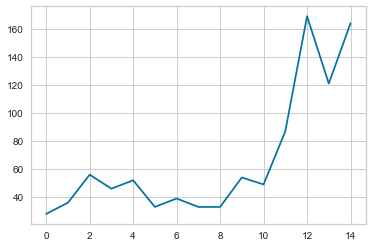

In [24]:
#number of articles published per date (dates with 0 articles are not ont he chart)
plt.plot(df.Abstract.groupby(df.Year).count().tolist())
plt.show()

----

### Pre-processing:  Lemmatizing & Tokenization

### Creating corpus1 and corpus2

In [7]:
#Select the words that are not numeric and longer than 1 character
#New variable: corpus2

from nltk.tokenize import RegexpTokenizer
import gensim
from gensim.utils import simple_preprocess

#def remove_stopwords(texts):
#    return [[word for word in simple_preprocess(str(doc)) 
#            if word not in my_stop_words] for doc in texts]

corpus_tkn = corpus.copy()

tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(corpus)):
    corpus_tkn[idx] = tokenizer.tokenize(str(corpus[idx]))

corpus2 = [[token for token in doc if not token.isnumeric()] for doc in corpus_tkn]
corpus2 = [[token for token in doc if len(token) > 1] for doc in corpus_tkn]

C:\Users\USER\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [8]:
# Includes bigrams and trigrams to corpus2
# Create corpus1 that is the same of corpus2 but WITHOUT bitrigrams
corpus1 = corpus2.copy()

#bigram = gensim.models.Phrases(corpus2, min_count=100, threshold=100) # higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[corpus2], threshold=100)  
#bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=my_stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'], bi = True, tri = True):
    """
    Remove Stopwords, Lemmatization and Form Bigrams and Trigrams [if bi = True, tri = True (by default)]
    If bi and tri are set to false, Bigrams and Trigrams are not added to texts
    
    """
    texts = [[word for word in simple_preprocess(str(doc)) if word not in my_stop_words] for doc in texts]
    
    if bi:
        bigram = gensim.models.Phrases(texts, min_count=100, threshold=100)
        bigram_mod = gensim.models.phrases.Phraser(bigram)
        texts = [bigram_mod[doc] for doc in texts]
    if tri:
        trigram = gensim.models.Phrases(bigram[texts], threshold=100)
        trigram_mod = gensim.models.phrases.Phraser(trigram)
        texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

corpus2 = process_words(corpus2)  # processed Text Data!
corpus1 = process_words(corpus1 , bi = False, tri = False)

In [36]:
#Bigram statistics
bi = []
for word in list(chain(*corpus2)):
    if '_' in word:
        bi.append(word)

count = []
for i in np.unique(bi):
    c = 0
    for j in list(chain(*corpus2)):
        if i == j:
            c += 1
    count.append(c)

count_describe = pd.DataFrame(count)





In [37]:
count_describe = count_describe.describe()
bigram_count = dict(zip(np.unique(bi), count))


In [38]:
import collections

d = collections.Counter(bigram_count)
d.most_common(15)

[('decision_making', 64),
 ('human_science', 63),
 ('neural_network', 49),
 ('end_user', 37),
 ('decision_make', 32),
 ('decision_maker', 31),
 ('busn_re', 26),
 ('time_serie', 26),
 ('life_cycle', 18),
 ('elsevier_ipma', 17),
 ('north_holland', 17),
 ('market_share', 15),
 ('problem_solving', 15),
 ('machine_learne', 14),
 ('small_businesse', 14)]

In [39]:
#unigram statistics
uni = []
for word in list(chain(*corpus1)):
    
    uni.append(word)

count1 = []
for i in np.unique(uni):
    c = 0
    for j in list(chain(*corpus1)):
        if i == j:
            c += 1
    count1.append(c)

count1 = pd.DataFrame(count1)
count1_describe = count1.describe()

# (Very) Basic sentiment analysis

In [9]:
from scipy.stats import spearmanr

# Sentiment analysis using textblob
from textblob import TextBlob

subjectivity_list = []
polarity_list =[]
corpus1_as_sentence = []

for abstr in corpus1:
    corpus1_as_sentence.append(" ".join(abstr))

for abstr in corpus1_as_sentence:
    # TextBlob().sentiment returns the sentiment associated with a sentence (or sentences in this case)
    subjectivity_list.append(TextBlob(abstr).sentiment[1]) # [1] because we take only the subjetivity measure
    polarity_list.append(TextBlob(abstr).sentiment[0])# with .sentiment[0] we get an index in the range [-1,+1] that reports the positity/negativity of the sentence

# merge it with the dataframe
df["corpus1_token"] = corpus1
df["corpus1"] = corpus1_as_sentence
df["abs_subjectivity"] = subjectivity_list
df["abs_polarity"] = polarity_list
# print(max(df["abs_subjectivity"]))
# print(min(df["abs_subjectivity"]))

# check if correlated (rank-order spearman's correlation) with number of citations
print("subjectivity:")
print(spearmanr(df["abs_subjectivity"], df['Cited by']))
print("polarity:")
print(spearmanr(df["abs_polarity"], df['Cited by']))

# and with citations/years from pubblication
years_from_pub = 2021-df.Year

print("subjectivity:")
print(spearmanr(df["abs_subjectivity"], df['Cited by']/years_from_pub))
print("polarity:")
print(spearmanr(df["abs_polarity"], df['Cited by']/years_from_pub))

# check one of the most subjective sentences (does not sound that subjective)
print("\nMost subjective sentence according to TextBlog (from raw data):")
print(df[df["abs_subjectivity"] == max(df["abs_subjectivity"])].Abstract.values)
print("\nMost subjective sentence according to TextBlog (after data cleaning):")
print(df[df["abs_subjectivity"] == max(df["abs_subjectivity"])].corpus1.values)
#print(list((df["abs_subjectivity"] == max(df["abs_subjectivity"]))))

# Check the most negative sentence
print("\nMost negative sentence according to TextBlog:")
print(df[df["abs_polarity"] == min(df["abs_polarity"])].Abstract.values[0])

# just sanity check correlation between years from publication and number of citations
print(np.corrcoef(years_from_pub, df['Cited by']))

subjectivity:
SpearmanrResult(correlation=-0.054688085709638054, pvalue=1.6798512240650107e-06)
polarity:
SpearmanrResult(correlation=0.03234789195307631, pvalue=0.004639652125946124)
subjectivity:
SpearmanrResult(correlation=-0.025906128508926294, pvalue=0.023386825306891467)
polarity:
SpearmanrResult(correlation=0.0017941207104537828, pvalue=0.8752621870710525)

Most subjective sentence according to TextBlog (from raw data):
['student satisfaction can be measured through the concept of disconfirmation. disconfirmation is the difference between expectations concerning a service and the perceived value of the service. using regression analysis and the concept of disconfirmation, easily interpreted graphical displays can be produced to identify areas that are important to student satisfaction. this article illustrates this technique, using data collected in undergraduate decision sciences courses. © 1997, copyright taylor & francis group, llc.'
 'this article investigates the interactio

In [10]:
# Sentiment analysis using pysentiment2
import pysentiment2 as ps
lm = ps.LM()
list_scores = []
for i in range(0,len(corpus)):
    tokens = lm.tokenize(corpus[i])
    score = lm.get_score(tokens)
    list_scores.append(score)

In [11]:
# create dataframe od pysentiment2 scores with same index of df
df_sentiment = pd.DataFrame.from_dict(list_scores) 
df_sentiment.set_index(df.index, drop = True, inplace = True)

this study investigates the effects of rewards in a research and development (r&d) setting in which employees' inventive efforts lead to patented inventions. pay for performance (pfp) for inventions is associated with two challenges: low-quality inventions may be rewarded (false positives), and high-quality inventions may be overlooked (false negatives). building on previous findings regarding the motivational and informational effects of rewards, we use social identity theory to predict that different types of inventors react differently to such false positive and false negative information. specifically, we hypothesize that pfp that produces false positives has detrimental effects on corporate inventors with a taste for science, who are motivated by scientific prestige, reputation, and intellectual curiosity. the empirical results from survey data related to 3, 995 inventor-patent pairs show that, for this particular group of inventors, false positives are associated with reduced eff

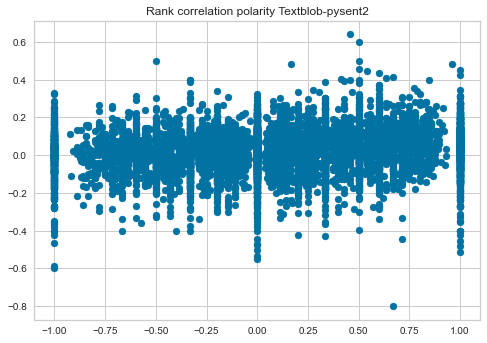

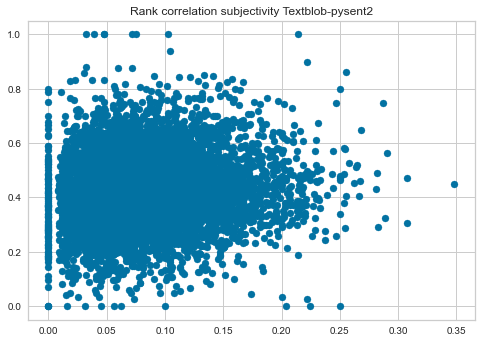

In [12]:
# printing most subjective sentence according to pysentiment2
print(df[df_sentiment.Subjectivity == max(df_sentiment.Subjectivity)].Abstract.values[0])

# Check correlation
print("CORRELATION WITH CITATIONS")
print("subjectivity:")
print(spearmanr(df_sentiment.Subjectivity, df['Cited by']))
print("polarity:")
print(spearmanr(df_sentiment.Polarity, df['Cited by']))

print("\nCORRELATION WITH CITATIONS/YEAR FROM PUBLICATION")
print("subjectivity:")
print(spearmanr(df_sentiment.Subjectivity, df['Cited by']/years_from_pub))
print("polarity:")
print(spearmanr(df_sentiment.Polarity, df['Cited by']/years_from_pub))

print("\nCORRELATION BETWEEN TEXBLOB AND PYSENT2")
print("subjectivity:")
print(spearmanr(df_sentiment.Subjectivity, df["abs_subjectivity"]))
print("polarity:")
print(spearmanr(df_sentiment.Polarity, df["abs_polarity"]))
plt.scatter(df_sentiment.Polarity, df["abs_polarity"])
plt.title("Rank correlation polarity Textblob-pysent2")
plt.show()
plt.scatter(df_sentiment.Subjectivity, df["abs_subjectivity"])
plt.title("Rank correlation subjectivity Textblob-pysent2")
plt.show()

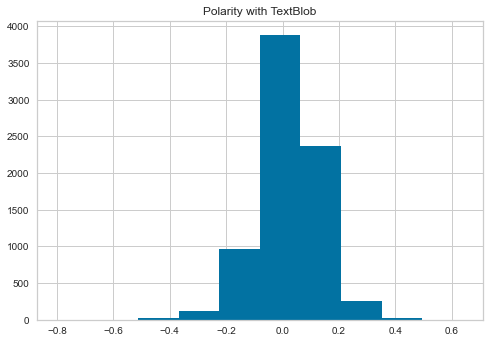

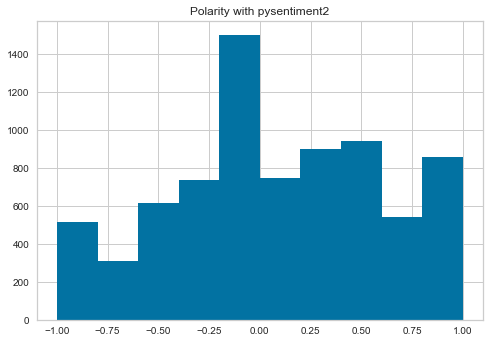

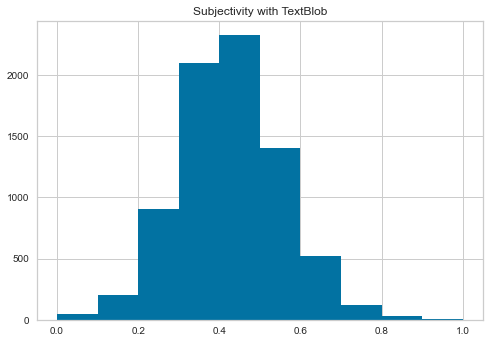

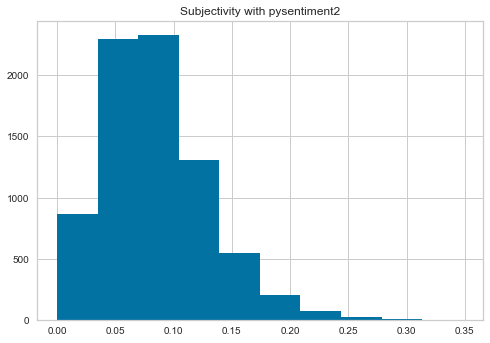

In [40]:
# HISTOGRAMS with the distribution of scores with the 2 packages
#plt.hist(df["abs_polarity"])
#plt.title("Polarity with TextBlob")
#plt.show()
#plt.hist(df_sentiment["Polarity"])
#plt.title("Polarity with pysentiment2")
#plt.show()
#plt.hist(df["abs_subjectivity"])
#plt.title("Subjectivity with TextBlob")
#plt.show()
#plt.hist(df_sentiment["Subjectivity"])
#plt.title("Subjectivity with pysentiment2")
#plt.show()

In [12]:
from collections import Counter
from bs4 import BeautifulSoup

# FOCUS TextBlob <--
# Read the file with the scores associated to each word in TextBlob
# HOWEVER notice that there are differences between these values and those obtained with TextBlob().sentiment
pattern_words_file = open(r"textblob_dict.txt", "r").read()

# Here we transform the html file into a dictionary of dictionaries
dict_of_dicts = {}
soup = BeautifulSoup(pattern_words_file,  "html.parser")
for line in soup.find_all("word"):
    # Try/except needed because sometimes "confidence" is called "reliability"
    try: 
        partial_dict = {'subjectivity' : line.attrs['subjectivity'],
                       'polarity' : line.attrs['polarity'],
                       'intensity' : line.attrs['intensity'],
                       'confidence' : line.attrs['confidence']}
    except:
        partial_dict = {'subjectivity' : line.attrs['subjectivity'],
                       'polarity' : line.attrs['polarity'],
                       'intensity' : line.attrs['intensity'],
                       'confidence' : line.attrs["reliability"]}
    dict_of_dicts[line.attrs["form"]] =  partial_dict

# And finally get the data in a DataFrame
Text_BloB_Dict = pd.DataFrame.from_dict(dict_of_dicts, orient = 'index')

# print percentiles of the TextBlob polarity distribution
perc = np.percentile(df["abs_polarity"], np.arange(0, 100, 1))[-1]
print("99th percentile polarity:", perc)

# Create a list with all the words of the abstracts in the top something% for polarity
all_words = []
for lista in df[df.abs_polarity>perc].corpus1_token: # Select only those abstract that are in top 1%
    all_words.extend(lista)
    
# Counting the most occuring words among these abstracts
wordz = pd.Series(Counter(all_words), index=Counter(all_words).keys())

# Printing subjectivity and polarity associated with those words that occur more than once in these abstract
sent_dict = {}
for w in wordz[wordz>1].index: # here this number should be such that we have a treatable number of words <---
    sent = TextBlob(w).sentiment
    if (sent[0]!= 0):
        word_dict = {"polarity" : sent[0], "subjectivity" : sent[1]}
        sent_dict[w] = word_dict
        
# SAME THING FOR SUBJECTIVITY
perc = np.percentile(df["abs_subjectivity"], np.arange(0, 100, 1))[-1]
print("\n 99th percentile SUBJECTIVITY:", perc)

# Create a list with all the words of the abstracts in the top something% for polarity
all_words = []
for lista in df[df.abs_subjectivity>perc].corpus1_token: # Select only those abstract that are in top 1%
    all_words.extend(lista)
    
# Counting the most occuring words among these abstracts
wordz = pd.Series(Counter(all_words), index=Counter(all_words).keys())
sent_word_data = pd.DataFrame.from_dict(sent_dict, orient = "index")
print(sent_word_data)
print(f"\nThe above are the {sent_word_data.polarity.size} most recurring words with a positive polarity score in the abstracts that have the top 1% score in terms of polarity")

99th percentile polarity: 0.28483005050505117

 99th percentile SUBJECTIVITY: 0.7531925133689845
              polarity  subjectivity
appropriate   0.500000      0.500000
certain       0.214286      0.571429
empirical     0.100000      0.100000
relevant      0.400000      0.900000
effectively   0.600000      0.800000
...                ...           ...
successfully  0.750000      0.950000
ethically     0.200000      0.600000
robotic      -0.100000      0.200000
ethical       0.200000      0.600000
artificially -0.600000      1.000000

[63 rows x 2 columns]

The above are the 63 most recurring words with a positive polarity score in the abstracts that have the top 1% score in terms of polarity


In [42]:
# Just checking a few words manually
# There are differences between these values and those of the Text_BloB_Dict DataFrame <---
print(TextBlob("new").sentiment)
print(TextBlob("different").sentiment)
print(TextBlob("new different").sentiment)
print(TextBlob("great idea for different reasons").sentiment)
print(TextBlob("I would say that this is a great different idea for the weekend car submarine road house bins").sentiment)

Sentiment(polarity=0.13636363636363635, subjectivity=0.45454545454545453)
Sentiment(polarity=0.0, subjectivity=0.6)
Sentiment(polarity=0.06818181818181818, subjectivity=0.5272727272727272)
Sentiment(polarity=0.4, subjectivity=0.675)
Sentiment(polarity=0.4, subjectivity=0.675)


In [13]:
# FOCUS Pysentiment2
# Reading the pysentiment2 disctionary
pysentiment2_dict = pd.read_csv(r"pysentiment2_dict.csv", sep = ";")
print(pysentiment2_dict.columns)
print(pysentiment2_dict.Word[:5])

tokens = lm.tokenize("this is a great idea for different reasons")
print(tokens)
print(lm.get_score(tokens))

all_words = []
for lista in df[df_sentiment.Polarity>0.99][:2].corpus1:
    all_words.extend(lm.tokenize(lista))
wordz = pd.Series(Counter(all_words), index=Counter(all_words).keys())
print(wordz[wordz>3].sort_values())

# checking characteristics of extremely positive sentences
for lista in df[df_sentiment.Polarity>0.99][:5].corpus1:
    print("\nNEW SENTENCE \n")
    for w in lm.tokenize(lista):
        if lm.get_score([w])["Polarity"]!= 0:
            print(w)
            print(lm.get_score([w]))

# Same for negative
for lista in df[df_sentiment.Polarity<-0.99][:5].corpus1:
    print("\nNEW SENTENCE \n")
    for w in lm.tokenize(lista):
        if lm.get_score([w])["Polarity"]!= 0:
            print(w)
            print(lm.get_score([w]))

Index(['Word', 'Sequence Number', 'Word Count', 'Word Proportion',
       'Average Proportion', 'Std Dev', 'Doc Count', 'Negative', 'Positive',
       'Uncertainty', 'Litigious', 'Constraining', 'Superfluous',
       'Interesting', 'Modal', 'Irr_Verb', 'Harvard_IV', 'Syllables',
       'Source'],
      dtype='object')
0     AARDVARK
1    AARDVARKS
2        ABACI
3        ABACK
4       ABACUS
Name: Word, dtype: object
['great', 'idea', 'differ', 'reason']
{'Positive': 1, 'Negative': 0, 'Polarity': 0.9999990000010001, 'Subjectivity': 0.24999993750001562}
patent    5
dtype: int64

NEW SENTENCE 

conclus
{'Positive': 1, 'Negative': 0, 'Polarity': 0.9999990000010001, 'Subjectivity': 0.9999990000010001}
depend
{'Positive': 1, 'Negative': 0, 'Polarity': 0.9999990000010001, 'Subjectivity': 0.9999990000010001}
invent
{'Positive': 1, 'Negative': 0, 'Polarity': 0.9999990000010001, 'Subjectivity': 0.9999990000010001}

NEW SENTENCE 

reward
{'Positive': 1, 'Negative': 0, 'Polarity': 0.9999990000010

## LDA - bigram + trigram + logistic regression


In [14]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
dictionary2 = Dictionary(corpus2)
dictionary2.filter_extremes(no_below=20, no_above=0.5)
bi_corpus = [dictionary2.doc2bow(doc) for doc in corpus2]

topic = []
perplexity= []
decay = []

num_topics = 20
temp = dictionary2[0]  # This is only to "load" the dictionary.

In [ ]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=bi_corpus,
                                           id2word=dictionary2,
                                           num_topics=k, 
                                           workers = 7,
                                           random_state=100,
                                           chunksize=200,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda1 = CoherenceModel(model=lda_model, texts=corpus2, dictionary=dictionary2, coherence='u_mass')
    coherence_model_lda2 = CoherenceModel(model=lda_model, texts=corpus2, dictionary=dictionary2, coherence='c_v')
    x = coherence_model_lda1.get_coherence()
    y = coherence_model_lda2.get_coherence()
    
    return x, y

In [ ]:
from gensim.models import CoherenceModel
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 5
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
beta.append('auto')

# Validation sets
num_of_docs = len(bi_corpus)
corpus_sets = bi_corpus

corpus_title = ['100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence_u': [],
                 'Coherence_v': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha va
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    u, v = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary2, 
                                                  k=k, a=a, b=b)
                    print(u, v)

                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence_u'].append(u)
                    model_results['Coherence_v'].append(v)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('./results/lda_tuning_results.csv', index=False)
    pbar.close()

In [ ]:
pd.DataFrame(model_results).to_csv('./results/lda_tuning_results.csv', index=False)

In [ ]:
pd.DataFrame(model_results).max

In [15]:
#The best model
#coherence_u: topic 12, alpha 0.81, beta 0.91
#coherence_v: topic 16, alpha: asymmetric, beta: 0.91
num_topics_u = 12

lda_model_u = gensim.models.LdaMulticore(corpus=bi_corpus,
                                           id2word=dictionary2,
                                           num_topics=num_topics_u, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           alpha=0.81,
                                           eta=0.91)

#num_topics_v = 16

#lda_model_v = gensim.models.LdaMulticore(corpus=bi_corpus,
 #                                          id2word=dictionary2,
  #                                         num_topics=num_topics_v, 
   #                                        random_state=100,
    #                                       chunksize=100,
     #                                      passes=20,
      #                                     alpha= 'asymmetric',
       #                                    eta=0.91)

In [ ]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model_u.print_topics())

In [ ]:
pprint(lda_model_v.print_topics())

In [16]:
#We need to plot the results

train_vecs = []
for i in range(len(df)):
    top_topics = (
        lda_model_u.get_document_topics(bi_corpus[i], minimum_probability = 0.0) #we capture the instances where a review is 
        #presented with 0% in some topics, and the representation for each review will add up to 100%
    )
    
    topic_vec = [top_topics[i][1] for i in range(num_topics_u)]
    train_vecs.append(topic_vec)
    
print(train_vecs[1])

[0.03143686, 0.08788353, 0.25687015, 0.021657499, 0.017308995, 0.04565976, 0.015628844, 0.15879776, 0.25600192, 0.021299783, 0.065782346, 0.021672573]


In [ ]:
#1990
print(df[df['Year'] == 1990].index)
print(df[df['Year'] == 2000].index)
print(df[df['Year'] == 2010].index)
print(df[df['Year'] == 2020].index)
dftrain_vecs_1990 = pd.DataFrame(train_vecs[749:781])
dftrain_vecs_2000 = pd.DataFrame(train_vecs[2844:3014])
dftrain_vecs_2010 = pd.DataFrame(train_vecs[6400:6731])
dftrain_vecs_2020 = pd.DataFrame(train_vecs[6732:7657])

In [ ]:
fig, ax = plt.subplots()
fig.set_figwidth(7)
fig.set_figheight(5)
ax.set_xlim([0,0.2])
(dftrain_vecs_1990.sum()/dftrain_vecs_1990.sum().sum()).plot(kind = 'barh')

fig, ax = plt.subplots()
fig.set_figwidth(7)
fig.set_figheight(5)
ax.set_xlim([0,0.2])
(dftrain_vecs_2000.sum()/dftrain_vecs_2000.sum().sum()).plot(kind = 'barh')

fig, ax = plt.subplots()
fig.set_figwidth(7)
fig.set_figheight(5)
ax.set_xlim([0,0.2])
(dftrain_vecs_2010.sum()/dftrain_vecs_2010.sum().sum()).plot(kind = 'barh')

fig, ax = plt.subplots()
fig.set_figwidth(7)
fig.set_figheight(5)
ax.set_xlim([0,0.2])
(dftrain_vecs_2020.sum()/dftrain_vecs_2020.sum().sum()).plot(kind = 'barh')

In [ ]:


fig, ax = plt.subplots()


fig.set_figwidth(7)
fig.set_figheight(5)
colors = ['black', 'slategray', 'lightcoral','peru','chocolate','darkorange',
          'yellow','greenyellow','darkgreen','aquamarine','cyan',
         'blue', 'violet','hotpink','pink','orchid','red','darkred']
bottom = np.zeros(len(agg_topics))

for i, col in enumerate(agg_topics.columns):
  ax.bar(agg_topics.index, agg_topics[col], bottom=bottom, label=col,
         color=colors[i])
  bottom += np.array(agg_topics[col])

ax.set_title('Topics by year')
ax.legend()


fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(5)

colors = ['black', 'slategray', 'lightcoral','peru','chocolate','darkorange',
          'yellow','greenyellow','darkgreen','aquamarine','cyan',
         'blue', 'violet','hotpink','pink','orchid','red','darkred']
bottom = np.zeros(len(agg_topics_1))

for i, col in enumerate(agg_topics_1.columns):
  ax.bar(agg_topics_1.index, agg_topics_1[col], bottom=bottom, label=col,
         color=colors[i])
  bottom += np.array(agg_topics_1[col])

ax.set_title('Topics by year (%)')
ax.legend()

In [ ]:
import pyLDAvis.gensim_models
import pickle
import pyLDAvis
import os

pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+ 'Final')

if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, bi_corpus, dictionary2)
    with open(LDAvis_data_filepath,'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
    
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ 'Final' + '.html')

In [ ]:
pyLDAvis.gensim_models.prepare(lda_model, bi_corpus, dictionary2)

In [ ]:
from collections import Counter

Counter(df.coverDate).keys()

In [ ]:
import pyLDAvis.gensim_models
import pickle
import pyLDAvis
import os

pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/lda_'+str(num_topics))

if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, bi_corpus, dictionary2)
    with open(LDAvis_data_filepath,'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
    
pyLDAvis.save_html(LDAvis_prepared, './results/lda_'+str(num_topics) + '.html')

# Word Embeddings

### Loading the pre-trained Google's word2vec model
How to make it work?
- Dowload Google's trained Word2Vec model at: https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
- unzip the .gz file

In [17]:
import gensim
# Load Google's pre-trained Word2Vec model.
#model = gensim.models.KeyedVectors.load_word2vec_format(r'C:\Users\marco\Desktop\NLP_local\notebook\data\GoogleNews-vectors-negative300.bin', binary=True)
model = gensim.models.KeyedVectors.load_word2vec_format(r'C:\Users\USER\OneDrive\Documents\Python\NLP\GoogleNews-vectors-negative300.bin', binary=True)

### Creating a sentence embedding for each abstract

In the cell below, we create the embedding for each word of the abstract using Google's word2vec model. Then we average all these vectors to obtain a unique abstract (sentence) embedding. This is repeated for all the abstracts in corpus1. Notice that corpus1 was created [here](#Creating-corpus1-and-corpus2).

In [18]:
# Create an empty list used to store the abstract embedding
list_word2vec_vector_max = []
list_word2vec_vector_mean = []
# Create an empty list to store the words that our model does not recognise
list_missing_word = []

# Loop all the abstracts in corpus1
for i in range(len(corpus1)):
    # Creating an empty list used to store the word embeddings of each word in the abstract
    word_matrix = []
    # Loop all the words in corpus1[i]
    for word in corpus1[i]:
        # Try/except is used here because if a word is not recognised by the model, an exception is raised
        try:
            # Embedding the word using our model
            word_vector = model[word]
            # Appending the embedding to the list of embeddings
            word_matrix.append(word_vector)
        except Exception as e:
            # If the word is not recognised, it is stored in the list below
            list_missing_word.append(word)
    # Take the average over all the word embeddings of an abstract
    sentence_embedding_max = np.max(np.asarray(word_matrix), axis = 0)
    sentence_embedding_mean = np.mean(np.asarray(word_matrix), axis = 0)
    # Append the average vector to the list below
    list_word2vec_vector_max.append(sentence_embedding_max)
    list_word2vec_vector_mean.append(sentence_embedding_mean)

In [47]:
# Checking the words that are not recognised by the model
print(set(list_missing_word))
print(np.shape(word_vector)) # Check size of a word vector (must be 300)
print(np.shape(word_matrix)) # Check size word matrix (must be equal to num of words in abstract minus the words that are not recognised)
print(len(list_word2vec_vector_mean[0])) # Check size of abstract vector (must be 300)

{'preregistere', 'itprosocial', 'unicauca', 'cwl', 'lss', 'hine', 'denisi', 'reba', 'prosociality', 'curvilinearly', 'vanet', 'precisionof', 'wouldndard', 'duhlberg', 'pronpo', 'reynold', 'holbrook', 'discretize', 'sheehan', 'matically', 'bravadoa', 'abductive', 'messner', 'papatheodorou', 'mcquillin', 'omani', 'markham', 'guangdong', 'linh', 'balachandran', 'industriale', 'ctsa', 'amersfoort', 'overfitte', 'boreca', 'asynchronicity', 'ecsr', 'lorena', 'ccfs', 'worldcat', 'dqc', 'dvm', 'enrolment', 'charlier', 'scotiabank', 'analogie', 'habermas', 'azsecure', 'iug', 'gsd', 'nonfranchise', 'nesta', 'predstave', 'gsdl', 'jame', 'threelayer', 'derivedby', 'autocorrelated', 'cyberharasser', 'megacitie', 'multischool', 'npo', 'ddb', 'zhongguancun', 'kirznerian', 'minitab', 'politecnica', 'budap', 'scaleit', 'screenwrite', 'swb', 'hyp', 'npi', 'astec', 'taguchi', 'maguire', 'cplex', 'blount', 'unimap', 'navs', 'werner', 'venturesserve', 'jbf', 'gbc', 'discretise', 'bof', 'rouwenhorst', 'lbo'

### Penalized Logistic model to predict number of citations with abstract embeddings

Run a (penalized) logistic regression to see if the asbtract embeddings using Google's word2vec model have any predictive power of the number of citations.
The y variable used is the same defined [here](#logistic-regression-(unigram)). The x variables are the 300 values of the asbtract embeddings. 

In [34]:

print(sum(y)/y.size)
# Check that y vector has the same order of df
print(y[:10])
print(df["Cited by"][:10])
# check that corpus1 has the same order of df
print(df.Abstract[:2])
print(corpus1[:2])

0.8891355445285976
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0     19.0
1     22.0
2     20.0
3     88.0
4     13.0
5    138.0
6     63.0
7    298.0
8     12.0
9     13.0
Name: Cited by, dtype: float64
0    this article extends a foucauldian view of pow...
1    this paper focuses on the strategic role and t...
Name: Abstract, dtype: object
[['article', 'extend', 'foucauldian', 'view', 'power', 'knowledge', 'archetypical', 'knowledge', 'intensive', 'organization', 'scientific', 'research', 'laboratory', 'foucault', 'hesitate', 'extend', 'analytic', 'power', 'hard', 'rhetorical', 'social', 'study', 'provide', 'foundation', 'extension', 'article', 'discursive', 'production', 'power', 'knowledge', 'big', 'laboratory', 'conduct', 'nuclear', 'fusion', 'research', 'illuminate', 'critical', 'incident', 'fusion', 'research', 'discipline', 'impose', 'normative', 'discipline', 'individual', 'scientist', 'research', 'team', 'scientific', 'knowledge', 'solely', 'product', 'datum', 'theory', 'emerge', 'discur

In [19]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
import numpy as np

def logit_model(X, y, C_grid, multi = False):
    '''
    This function takes a grid of values of the tuning parameter and returns a dictionary with the f1_Score and accuracy 
    on a 10-fold cross validation
    '''
    w2c_logit_acc = {}

    for C in C_grid:
        # Set K-Folds cross-validator
        kf = StratifiedKFold(10, shuffle = True, random_state = 42)

        # Empty lists to store the mean accuracy (lr_score) and balanced F-score (cv_lr_f1)
        lr_score , cv_lr_f1= [], []

        for train_ind, val_ind in kf.split(X,y):
            X_train, y_train = X[train_ind], y[train_ind]
            X_val, y_val = X[val_ind], y[val_ind]

            # Notice that I am NOT normalizing the data <<---

            # Set logistic regression model
            if multi == False:
                lr = LogisticRegression(
                class_weight = 'balanced',
                solver = 'saga',
                fit_intercept = True,
                max_iter = 100000, 
                C = C # Penalization parameter
            ).fit(X_train, y_train)
                y_pred = lr.predict(X_val)
                cv_lr_f1.append(f1_score(y_val, y_pred, average='binary'))
                
            
            
            else:
                lr = LogisticRegression(
                class_weight = 'balanced',
                multi_class='multinomial',
                solver = 'saga',
                fit_intercept = True,
                max_iter = 100000, 
                C = C # Penalization parameter
            ).fit(X_train, y_train)
                y_pred = lr.predict(X_val)
                cv_lr_f1.append(f1_score(y_val, y_pred, average='weighted'))

            # Computing mean accuracy and balanced F-score
            
            
        
                
            
        lr_score.append(lr.score(X_val, y_val))
        F1_score = np.mean(cv_lr_f1)
        acc_score = np.mean(lr_score)
        print(f"\n using {C} as penalization parameter")
        print(f'Logistic Regression Val f1: {F1_score:.3f} +- {np.std(cv_lr_f1):.3f}')
        print(f'Logistic Regression Accuracy:{acc_score}')
        print("Coefficients bigger than 0.1:", sum(sum(lr.coef_>0.1))) # Check number of coefficient bigger than 0.1
        w2c_logit_c = {"F1_score" : F1_score, "acc_score" : acc_score}
        w2c_logit_acc[C] = w2c_logit_c
    return w2c_logit_acc



In [50]:
#LDA
# Setting X as the predictior of the model (i.e. the abstract sentence embedding)
y = np.array(df["Cited by"])
y[y==0] = 0
y[y>0] = 1
X = np.column_stack([train_vecs]) # We use the max
scaler = StandardScaler()
#X = scaler.fit_transform(X)
# Set the grid
C_grid = [100, 10, 5, 2.5, 1, 0.1, 0.05, 0.025, 0.01, 0.000001]
# Sort sample in test and train/validation
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.1, stratify=y)
lda_logit = logit_model(X_train, y_train, C_grid, multi = False)

print(f'\nNow, we use multinomial logit')
y = np.array(df["Cited by"])
m_y = pd.cut(y, [-np.inf,1,51,np.inf], labels=[0,1,2])
print(y)
X = np.column_stack([train_vecs]) # We use the max
scaler = StandardScaler()
# Set the grid
C_grid = [100, 10, 5, 2.5, 1, 0.1, 0.05, 0.025, 0.01, 0.000001]
# Sort sample in test and train/validation
m_X_train, m_X_test, m_y_train, m_y_test = train_test_split(X, m_y,  test_size=0.1, stratify=m_y)
m_lda_logit = logit_model(m_X_train, m_y_train, C_grid, multi= True)


lda_logit_df = pd.DataFrame.from_dict(lda_logit, orient = "index")
m_lda_logit_df = pd.DataFrame.from_dict(m_lda_logit, orient = "index")
print(lda_logit_df)
print(m_lda_logit_df)
# Select the best value of C for abstract embedding with max
max_c = max(lda_logit_df.F1_score)
m_max_c = max(m_lda_logit_df.F1_score)

lda_logit_df.loc[lda_logit_df.F1_score == max_c, :].index
m_lda_logit_df.loc[m_lda_logit_df.F1_score == m_max_c, :].index

# Training again the model on the entire train set with c = max_c
lr_lda_best = LogisticRegression(
                class_weight = 'balanced',
                solver = 'saga',
                fit_intercept = True,
                max_iter = 10000, 
                C = max_c # Penalization parameter set to max_c
            ).fit(X_train, y_train)

m_lr_lda_best = LogisticRegression(
                class_weight = 'balanced',
                solver = 'saga',
                fit_intercept = True,
                max_iter = 10000, 
                C = m_max_c # Penalization parameter set to max_c
            ).fit(m_X_train, m_y_train)
# Computing mean accuracy and balanced F-score on train dataset
y_pred = lr_lda_best.predict(X_test)
m_y_pred = m_lr_lda_best.predict(m_X_test)
print("f1_score on test:", f1_score(y_test, y_pred, average='binary'))
print("Accuracy on test:", lr_lda_best.score(X_test, y_test))

print('Now we print multiclass prediction')
print("f1_score on test:", f1_score(m_y_test, m_y_pred, average='weighted'))
print("Accuracy on test:", m_lr_lda_best.score(m_X_test, m_y_test))


 using 100 as penalization parameter
Logistic Regression Val f1: 0.691 +- 0.017
Logistic Regression Accuracy:0.5776487663280117
Coefficients bigger than 0.1: 5

 using 10 as penalization parameter
Logistic Regression Val f1: 0.691 +- 0.018
Logistic Regression Accuracy:0.579100145137881
Coefficients bigger than 0.1: 5

 using 5 as penalization parameter
Logistic Regression Val f1: 0.691 +- 0.018
Logistic Regression Accuracy:0.5805515239477503
Coefficients bigger than 0.1: 5

 using 2.5 as penalization parameter
Logistic Regression Val f1: 0.691 +- 0.018
Logistic Regression Accuracy:0.5805515239477503
Coefficients bigger than 0.1: 5

 using 1 as penalization parameter
Logistic Regression Val f1: 0.691 +- 0.017
Logistic Regression Accuracy:0.579100145137881
Coefficients bigger than 0.1: 5

 using 0.1 as penalization parameter
Logistic Regression Val f1: 0.700 +- 0.012
Logistic Regression Accuracy:0.579100145137881
Coefficients bigger than 0.1: 5

 using 0.05 as penalization parameter
Log

In [52]:
#sentiment - textblob: subjectivity
# Setting X as the predictior of the model (i.e. the abstract sentence embedding)
y = np.array(df["Cited by"])
y[y==0] = 0
y[y>0] = 1
X = np.column_stack([df["abs_subjectivity"]]) # We use the max
scaler = StandardScaler()
#X = scaler.fit_transform(X)
# Set the grid
C_grid = [100, 10, 5, 2.5, 1, 0.1, 0.05, 0.025, 0.01, 0.000001]
# Sort sample in test and train/validation
senti_logit = logit_model(X_train, y_train, C_grid, multi = False)

print(f'\nNow, we use multinomial logit')
y = np.array(df["Cited by"])
m_y = pd.cut(y, [-np.inf,1,51,np.inf], labels=[0,1,2])
C_grid = [100, 10, 5, 2.5, 1, 0.1, 0.05, 0.025, 0.01, 0.000001]
m_X_train, m_X_test, m_y_train, m_y_test = train_test_split(X, m_y,  test_size=0.1, stratify=m_y)
# Sort sample in test and train/validation
m_senti_logit = logit_model(m_X_train, m_y_train, C_grid, multi = True)


sub_logit_df = pd.DataFrame.from_dict(senti_logit, orient = "index")
m_sub_logit_df = pd.DataFrame.from_dict(m_senti_logit, orient = "index")
print(sub_logit_df)
print(m_sub_logit_df)
# Select the best value of C for abstract embedding with max
max_c = max(sub_logit_df.F1_score)
m_max_c = max(m_sub_logit_df.F1_score)

sub_logit_df.loc[sub_logit_df.F1_score == max_c, :].index
m_sub_logit_df.loc[m_sub_logit_df.F1_score == m_max_c, :].index

# Training again the model on the entire train set with c = max_c
lr_sub_best = LogisticRegression(
                class_weight = 'balanced',
                solver = 'saga',
                fit_intercept = True,
                max_iter = 10000, 
                C = max_c # Penalization parameter set to max_c
            ).fit(X_train, y_train)

m_lr_sub_best = LogisticRegression(
                class_weight = 'balanced',
                solver = 'saga',
                fit_intercept = True,
                max_iter = 10000, 
                C = m_max_c # Penalization parameter set to max_c
            ).fit(m_X_train, m_y_train)
# Computing mean accuracy and balanced F-score on train dataset
y_pred = lr_sub_best.predict(X_test)
m_y_pred = m_lr_sub_best.predict(m_X_test)
print("f1_score on test:", f1_score(y_test, y_pred, average='binary'))
print("Accuracy on test:", lr_sub_best.score(X_test, y_test))

print('Now we print multiclass prediction')
print("f1_score on test:", f1_score(m_y_test, m_y_pred, average='weighted'))
print("Accuracy on test:", m_lr_sub_best.score(m_X_test, m_y_test))


 using 100 as penalization parameter
Logistic Regression Val f1: 0.691 +- 0.017
Logistic Regression Accuracy:0.5776487663280117
Coefficients bigger than 0.1: 5

 using 10 as penalization parameter
Logistic Regression Val f1: 0.691 +- 0.018
Logistic Regression Accuracy:0.579100145137881
Coefficients bigger than 0.1: 5

 using 5 as penalization parameter
Logistic Regression Val f1: 0.691 +- 0.018
Logistic Regression Accuracy:0.5805515239477503
Coefficients bigger than 0.1: 5

 using 2.5 as penalization parameter
Logistic Regression Val f1: 0.691 +- 0.018
Logistic Regression Accuracy:0.5805515239477503
Coefficients bigger than 0.1: 5

 using 1 as penalization parameter
Logistic Regression Val f1: 0.691 +- 0.017
Logistic Regression Accuracy:0.579100145137881
Coefficients bigger than 0.1: 5

 using 0.1 as penalization parameter
Logistic Regression Val f1: 0.700 +- 0.012
Logistic Regression Accuracy:0.579100145137881
Coefficients bigger than 0.1: 5

 using 0.05 as penalization parameter
Log

In [53]:
#sentiment - textblob: polarity
# Setting X as the predictior of the model (i.e. the abstract sentence embedding)
y = np.array(df["Cited by"])
y[y==0] = 0
y[y>0] = 1

X = np.column_stack([df["abs_polarity"]]) # We use the max
scaler = StandardScaler()
#X = scaler.fit_transform(X)
# Set the grid
C_grid = [100, 10, 5, 2.5, 1, 0.1, 0.05, 0.025, 0.01, 0.000001]
# Sort sample in test and train/validation
X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(X, y,  test_size=0.1,stratify=y)
pol_logit = logit_model(X_train_max, y_train_max, C_grid, multi = False)

print(f'\nNow, we use multinomial logit')
C_grid = [100, 10, 5, 2.5, 1, 0.1, 0.05, 0.025, 0.01, 0.000001]
X = np.column_stack([df["abs_polarity"]]) 
y = np.array(df["Cited by"])
m_y = pd.cut(y, [-np.inf,1,51,np.inf], labels=[0,1,2])
m_X_train, m_X_test, m_y_train, m_y_test = train_test_split(X, m_y,  test_size=0.1, stratify=m_y)

# Sort sample in test and train/validation
m_pol_logit = logit_model(m_X_train, m_y_train, C_grid, multi = True)

pol_logit_df = pd.DataFrame.from_dict(pol_logit, orient = "index")
m_pol_logit_df = pd.DataFrame.from_dict(m_pol_logit, orient = "index")
print(pol_logit_df)
print(m_pol_logit_df)
# Select the best value of C for abstract embedding with max
max_c = max(pol_logit_df.F1_score)
m_max_c = max(m_pol_logit_df.F1_score)

pol_logit_df.loc[pol_logit_df.F1_score == max_c, :].index
m_pol_logit_df.loc[m_pol_logit_df.F1_score == m_max_c, :].index

# Training again the model on the entire train set with c = max_c
lr_pol_best = LogisticRegression(
                class_weight = 'balanced',
                solver = 'saga',
                fit_intercept = True,
                max_iter = 10000, 
                C = max_c # Penalization parameter set to max_c
            ).fit(X_train, y_train)

m_lr_pol_best = LogisticRegression(
                class_weight = 'balanced',
                solver = 'saga',
                fit_intercept = True,
                max_iter = 10000, 
                C = m_max_c # Penalization parameter set to max_c
            ).fit(m_X_train, m_y_train)
# Computing mean accuracy and balanced F-score on train dataset
y_pred = lr_pol_best.predict(X_test)
m_y_pred = m_lr_pol_best.predict(m_X_test)
print("f1_score on test:", f1_score(y_test, y_pred, average='binary'))
print("Accuracy on test:", lr_pol_best.score(X_test, y_test))

print('Now we print multiclass prediction')
print("f1_score on test:", f1_score(m_y_test, m_y_pred, average='weighted'))
print("Accuracy on test:", m_lr_pol_best.score(m_X_test, m_y_test))


 using 100 as penalization parameter
Logistic Regression Val f1: 0.668 +- 0.034
Logistic Regression Accuracy:0.46879535558780844
Coefficients bigger than 0.1: 1

 using 10 as penalization parameter
Logistic Regression Val f1: 0.664 +- 0.020
Logistic Regression Accuracy:0.502177068214804
Coefficients bigger than 0.1: 1

 using 5 as penalization parameter
Logistic Regression Val f1: 0.666 +- 0.019
Logistic Regression Accuracy:0.5108853410740203
Coefficients bigger than 0.1: 1

 using 2.5 as penalization parameter
Logistic Regression Val f1: 0.665 +- 0.019
Logistic Regression Accuracy:0.5007256894049347
Coefficients bigger than 0.1: 1

 using 1 as penalization parameter
Logistic Regression Val f1: 0.665 +- 0.020
Logistic Regression Accuracy:0.502177068214804
Coefficients bigger than 0.1: 1

 using 0.1 as penalization parameter
Logistic Regression Val f1: 0.635 +- 0.091
Logistic Regression Accuracy:0.49927431059506533
Coefficients bigger than 0.1: 1

 using 0.05 as penalization parameter


In [54]:
#Word Embedding
# Setting X as the predictior of the model (i.e. the abstract sentence embedding)
y = np.array(df["Cited by"])
y[y==0] = 0
y[y>0] = 1

X = np.column_stack([list_word2vec_vector_max]) # We use the max
#scaler = StandardScaler()
#X = scaler.fit_transform(X)

# Set the grid
C_grid = [10, 1, 0.1, 0.05, 0.025, 0.01, 0.000001]

# Sort sample in test and train/validation
X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(X, y,  test_size=0.1,stratify=y)
w2c_logit_acc_max = logit_model(X_train_max, y_train_max, C_grid, multi = False)

# Setting X as the predictior of the model (i.e. the abstract sentence embedding)
X = np.column_stack([list_word2vec_vector_mean]) # We use the mean
# Sort sample in test and train/validation
#X = scaler.fit_transform(X)
X_train_mean, X_test_mean, y_train_mean, y_test_mean = train_test_split(X, y,  test_size=0.1,stratify=y)
# Set a new grid
C_grid = [100, 10, 5, 2.5, 1, 0.1, 0.000001]
w2c_logit_acc_mean = logit_model(X_train_mean, y_train_mean, C_grid, multi = False)

print(f'\nNow, we use multinomial logit')
X = np.column_stack([list_word2vec_vector_max])
y = np.array(df["Cited by"])
m_y = pd.cut(y, [-np.inf,1,51,np.inf], labels=[0,1,2])
C_grid = [10, 1, 0.1, 0.05, 0.025, 0.01, 0.000001]
# Sort sample in test and train/validation
m_X_train_max, m_X_test_max, m_y_train_max, m_y_test_max = train_test_split(X, m_y,  test_size=0.1,stratify=m_y)
m_w2c_logit_acc_max = logit_model(m_X_train_max, m_y_train_max, C_grid, multi = True)

# Setting X as the predictior of the model (i.e. the abstract sentence embedding)
X = np.column_stack([list_word2vec_vector_mean])# We use the mean
# Sort sample in test and train/validation
#X = scaler.fit_transform(X)
m_X_train_mean, m_X_test_mean, m_y_train_mean, m_y_test_mean = train_test_split(X, m_y,  test_size=0.1,stratify=m_y)
# Set a new grid
C_grid = [100, 10, 5, 2.5, 1, 0.1, 0.000001]
m_w2c_logit_acc_mean = logit_model(m_X_train_mean, m_y_train_mean, C_grid, multi = True)



C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "



 using 10 as penalization parameter
Logistic Regression Val f1: 0.773 +- 0.009
Logistic Regression Accuracy:0.648766328011611
Coefficients bigger than 0.1: 141

 using 1 as penalization parameter
Logistic Regression Val f1: 0.773 +- 0.009
Logistic Regression Accuracy:0.6531204644412192
Coefficients bigger than 0.1: 138

 using 0.1 as penalization parameter
Logistic Regression Val f1: 0.767 +- 0.010
Logistic Regression Accuracy:0.637155297532656
Coefficients bigger than 0.1: 114

 using 0.05 as penalization parameter
Logistic Regression Val f1: 0.764 +- 0.010
Logistic Regression Accuracy:0.6226415094339622
Coefficients bigger than 0.1: 104

 using 0.025 as penalization parameter
Logistic Regression Val f1: 0.762 +- 0.011
Logistic Regression Accuracy:0.6153846153846154
Coefficients bigger than 0.1: 71

 using 0.01 as penalization parameter
Logistic Regression Val f1: 0.760 +- 0.013
Logistic Regression Accuracy:0.6110304789550073
Coefficients bigger than 0.1: 29

 using 1e-06 as penaliza

NameError: name 'm_X_train_mean' is not defined

In [55]:
X = np.column_stack([list_word2vec_vector_mean])# We use the mean
# Sort sample in test and train/validation
#X = scaler.fit_transform(X)
m_X_train_mean, m_X_test_mean, m_y_train_mean, m_y_test_mean = train_test_split(X, m_y,  test_size=0.1,stratify=m_y)
# Set a new grid
C_grid = [100, 10, 5, 2.5, 1, 0.1, 0.000001]
m_w2c_logit_acc_mean = logit_model(m_X_train_mean, m_y_train_mean, C_grid, multi = True)


 using 100 as penalization parameter
Logistic Regression Val f1: 0.452 +- 0.020
Logistic Regression Accuracy:0.45428156748911463
Coefficients bigger than 0.1: 434

 using 10 as penalization parameter
Logistic Regression Val f1: 0.453 +- 0.018
Logistic Regression Accuracy:0.45428156748911463
Coefficients bigger than 0.1: 426

 using 5 as penalization parameter
Logistic Regression Val f1: 0.449 +- 0.017
Logistic Regression Accuracy:0.45428156748911463
Coefficients bigger than 0.1: 426

 using 2.5 as penalization parameter
Logistic Regression Val f1: 0.441 +- 0.019
Logistic Regression Accuracy:0.44702467343976776
Coefficients bigger than 0.1: 409

 using 1 as penalization parameter
Logistic Regression Val f1: 0.430 +- 0.021
Logistic Regression Accuracy:0.4412191582002903
Coefficients bigger than 0.1: 387

 using 0.1 as penalization parameter
Logistic Regression Val f1: 0.348 +- 0.020
Logistic Regression Accuracy:0.3788098693759071
Coefficients bigger than 0.1: 254

 using 1e-06 as penali

In [56]:
w2c_logit_acc_max_df = pd.DataFrame.from_dict(m_w2c_logit_acc_max, orient = "index")
m_w2c_logit_acc_max_df = pd.DataFrame.from_dict(m_w2c_logit_acc_max, orient = "index")
print(w2c_logit_acc_max_df)
print(m_w2c_logit_acc_max_df)
# Select the best value of C for abstract embedding with max
max_c = max(w2c_logit_acc_max_df.F1_score)
m_max_c = max(m_w2c_logit_acc_max_df.F1_score)

w2c_logit_acc_max_df.loc[w2c_logit_acc_max_df.F1_score == max_c, :].index
m_w2c_logit_acc_max_df.loc[m_w2c_logit_acc_max_df.F1_score == m_max_c, :].index

           F1_score  acc_score
10.000000  0.458719   0.426705
1.000000   0.456400   0.435414
0.100000   0.438348   0.413643
0.050000   0.424821   0.412192
0.025000   0.403782   0.400581
0.010000   0.371160   0.365747
0.000001   0.241621   0.284470
           F1_score  acc_score
10.000000  0.458719   0.426705
1.000000   0.456400   0.435414
0.100000   0.438348   0.413643
0.050000   0.424821   0.412192
0.025000   0.403782   0.400581
0.010000   0.371160   0.365747
0.000001   0.241621   0.284470


Float64Index([10.0], dtype='float64')

In [57]:
# Training again the model on the entire train set with c = max_c
lr_max_best = LogisticRegression(
                class_weight = 'balanced',
                solver = 'saga',
                fit_intercept = True,
                max_iter = 10000, 
                C = max_c # Penalization parameter set to max_c
            ).fit(X_train_max, y_train_max)

m_lr_max_best = LogisticRegression(
                class_weight = 'balanced',
                solver = 'saga',
                fit_intercept = True,
                max_iter = 10000, 
                C = m_max_c # Penalization parameter set to max_c
            ).fit(m_X_train_max, m_y_train_max)
# Computing mean accuracy and balanced F-score on train dataset
y_pred = lr_max_best.predict(X_test_max)
m_y_pred = m_lr_max_best.predict(X_test_max)
print("f1_score on test:", f1_score(y_test_max, y_pred, average='binary'))
print("Accuracy on test:", lr_max_best.score(X_test_max, y_test_max))
print("Now we look at multinomial logit")

print("f1_score on test:", f1_score(m_y_test_max, m_y_pred, average='weighted'))
print("Accuracy on test:", m_lr_max_best.score(m_X_test_max, m_y_test_max))

f1_score on test: 0.7776824034334764
Accuracy on test: 0.6618798955613577
f1_score on test: 0.3569290928733767
Accuracy on test: 0.44386422976501305


In [58]:
w2c_logit_acc_mean_df = pd.DataFrame.from_dict(w2c_logit_acc_mean, orient = "index")
m_w2c_logit_acc_mean_df = pd.DataFrame.from_dict(m_w2c_logit_acc_mean, orient = "index")
print(w2c_logit_acc_mean_df)
print(m_w2c_logit_acc_mean_df)
# Select the best value of C for abstract embedding with mean
max_c = max(w2c_logit_acc_mean_df.F1_score)
m_max_c = max(m_w2c_logit_acc_mean_df.F1_score)
w2c_logit_acc_mean_df.loc[w2c_logit_acc_mean_df.F1_score == max_c, :].index
m_w2c_logit_acc_mean_df.loc[m_w2c_logit_acc_mean_df.F1_score == m_max_c, :].index

            F1_score  acc_score
100.000000  0.783720   0.654572
10.000000   0.784102   0.657475
5.000000    0.782491   0.658926
2.500000    0.775629   0.654572
1.000000    0.766486   0.650218
0.100000    0.745914   0.622642
0.000001    0.743781   0.711176
            F1_score  acc_score
100.000000  0.452458   0.454282
10.000000   0.452668   0.454282
5.000000    0.449279   0.454282
2.500000    0.440620   0.447025
1.000000    0.430368   0.441219
0.100000    0.348074   0.378810
0.000001    0.275897   0.377358


Float64Index([10.0], dtype='float64')

In [59]:
# Training again the model on the entire train set with c = max_c
lr_mean_best = LogisticRegression(
                class_weight = 'balanced',
                solver = 'saga',
                fit_intercept = True,
                max_iter = 10000, 
                C = max_c # Penalization parameter set to max_c
            ).fit(X_train_mean, y_train_mean)

m_lr_mean_best = LogisticRegression(
                class_weight = 'balanced',
                solver = 'saga',
                fit_intercept = True,
                max_iter = 10000, 
                C = m_max_c # Penalization parameter set to max_c
            ).fit(X_train_mean, y_train_mean)
# Computing mean accuracy and balanced F-score on train dataset


y_pred = lr_mean_best.predict(X_test_mean)
m_y_pred = m_lr_mean_best.predict(X_test_mean)
print("f1_score on test:", f1_score(y_test_mean, y_pred, average='binary'))
print("Accuracy on test:", lr_mean_best.score(X_test_mean, y_test_mean))

print("Now we look at multinomial logit")
m_y_pred = m_lr_mean_best.predict(X_test_mean)
print("f1_score on test:", f1_score(y_test_mean, m_y_pred, average='weighted'))
print("Accuracy on test:", m_lr_mean_best.score(X_test_mean, y_test_mean))

f1_score on test: 0.7672413793103448
Accuracy on test: 0.6475195822454308
Now we look at multinomial logit
f1_score on test: 0.7052537091071349
Accuracy on test: 0.6383812010443864


### LASSO
Running a LASSO model to predict the number of citations.

**Since probably we are not using LASSO do not mind about this part**

In [70]:
'''
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

def LASSO_model_w2v(X, y, C_grid):
    w2c_LASSO_mse = {}

    for C in C_grid:
        # Set K-Folds cross-validator
        k = 10
        kf = KFold(k, shuffle = True, random_state = 42)

        # Empty lists to store the mean accuracy (lr_score) and balanced F-score (cv_lr_f1)
        LASSO_mse = []

        for train_ind, val_ind in kf.split(X,y):
            X_train, y_train = X[train_ind], y[train_ind]
            X_val, y_val = X[val_ind], y[val_ind]

            # Notice that I am NOT normalizing the data <<---

            # Set logistic regression model
            lasso = Lasso(alpha = C).fit(X_train, y_train)

            # Computing mean accuracy and balanced F-score
            y_pred = lasso.predict(X_val)
            # print(y_pred[:20])
            LASSO_mse.append(mean_squared_error(y_pred, y_val))
        mse_score = np.mean(LASSO_mse)
        print(f"\n using {C} as penalization parameter")
        print(f'LASSO MSE: {mse_score:.3f} +- {np.std(LASSO_mse)/k:.3f}')
        print("Coefficients bigger than 0.01:", sum(lasso.coef_>0.01)) # Check number of coefficient bigger than 0.1
        w2c_LASSO_c = {"mse" : mse_score, "sd" : np.std(LASSO_mse)/k}
        w2c_LASSO_mse[C] = w2c_LASSO_c
    return w2c_LASSO_mse


X = np.column_stack([list_word2vec_vector_max])

years_from_pub = 2021-df.Year

X_pos = X[y>0]
y_pos = df["Cited by"][y>0]

C_grid = [1,  0.5, 0.25, 0.1, 0.075, 0.05, 1e-5]
w2c_lasso_mse_max = LASSO_model_w2v(X, df["Cited by"], C_grid)
w2c_lasso_mse_max = pd.DataFrame.from_dict(w2c_lasso_mse_max, orient = "index")

X = np.column_stack([list_word2vec_vector_mean])
X_pos = X[y>0]

C_grid = [1,0.1, 0.05, 0.025, 0.01, 0.005, 1e-5]
w2c_lasso_mse_mean = LASSO_model_w2v(X, df["Cited by"], C_grid)
w2c_lasso_mse_mean = pd.DataFrame.from_dict(w2c_lasso_mse_mean, orient = "index")
print(w2c_lasso_mse_max)
print(w2c_lasso_mse_mean)

X = np.column_stack([list_word2vec_vector_max])
X_pos = X[y>0]
y_pos = df["Cited by"][y>0]

C_grid = [1,  0.05, 0.025, 0.01, 0.0075, 0.005, 1e-5]
w2c_lasso_mse_max = LASSO_model_w2v(X, df["Cited by"]/years_from_pub, C_grid)
w2c_lasso_mse_max = pd.DataFrame.from_dict(w2c_lasso_mse_max, orient = "index")

X = np.column_stack([list_word2vec_vector_mean])
X_pos = X[y>0]

C_grid = [1, 0.01, 0.005, 0.0025, 0.001, 0.0005, 1e-5]
w2c_lasso_mse_mean = LASSO_model_w2v(X, df["Cited by"]/years_from_pub, C_grid)
w2c_lasso_mse_mean = pd.DataFrame.from_dict(w2c_lasso_mse_mean, orient = "index")

print(w2c_lasso_mse_max)
print(w2c_lasso_mse_mean)
'''

'\nfrom sklearn.linear_model import Lasso\nfrom sklearn.metrics import mean_squared_error\n\ndef LASSO_model_w2v(X, y, C_grid):\n    w2c_LASSO_mse = {}\n\n    for C in C_grid:\n        # Set K-Folds cross-validator\n        k = 10\n        kf = KFold(k, shuffle = True, random_state = 42)\n\n        # Empty lists to store the mean accuracy (lr_score) and balanced F-score (cv_lr_f1)\n        LASSO_mse = []\n\n        for train_ind, val_ind in kf.split(X,y):\n            X_train, y_train = X[train_ind], y[train_ind]\n            X_val, y_val = X[val_ind], y[val_ind]\n\n            # Notice that I am NOT normalizing the data <<---\n\n            # Set logistic regression model\n            lasso = Lasso(alpha = C).fit(X_train, y_train)\n\n            # Computing mean accuracy and balanced F-score\n            y_pred = lasso.predict(X_val)\n            # print(y_pred[:20])\n            LASSO_mse.append(mean_squared_error(y_pred, y_val))\n        mse_score = np.mean(LASSO_mse)\n        print